# Настройка

In [0]:
!pip install -q bigartm10
!pip install -q pymorphy2

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 8.2MB/s 


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import artm
import nltk
import collections
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
gDrivePath = "/content/drive/My Drive/DL NLP/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
name = 'bank_train.xml'
df = pd.DataFrame()
rows = []
with open(gDrivePath+name, "r") as f:
    
    contents = f.read()
 
    soup = BeautifulSoup(contents, 'xml')
    for row in soup.find_all('table')[1:]:
        tag = {}
        for elem in row.find_all('column'):
            tag[elem['name']] = elem.string
        
        tag['links'] = re.findall(r'http\S+', tag['text'])
        tag['tags'] = re.findall(r'@\w+', tag['text'])
        tag['hash'] = re.findall(r'#\w+', tag['text'])
        t = re.sub(r'#\S+|@\w+|http\S+\s*|RT|cc|\d', '', tag['text'])
        t = re.sub(r'[%s]' % re.escape(r"""!"#$%&'()*+,-./:;<=>?@[\]^_«»“”’*…/_.\\`{|}~"""), '', t)
        tag['text'] = re.sub(r'\s+', ' ', t).lower()
        rows.append(tag)
df = pd.DataFrame(rows)
df.head()

,id,twitid,date,text,sberbank,vtb,gazprom,alfabank,bankmoskvy,raiffeisen,uralsib,rshb,links,tags,hash
0,1,492367586156630000,1406224554,взять кредит тюмень альфа банк,NULL,NULL,NULL,0,NULL,NULL,NULL,NULL,[http://t.co/YEVHuvVGA1],[],[]
1,2,492368160923070000,1406224691,мнение о кредитной карте втб,NULL,0,NULL,NULL,NULL,NULL,NULL,NULL,[http://t.co/SBJTcsqjCg],[],[]
2,3,492368608346260000,1406224798,райффайзенбанк снижение ключевой ставки цб на ...,NULL,NULL,NULL,NULL,NULL,0,NULL,NULL,[],[],[]
3,4,492371181946030000,1406225412,современное состояние кредитного поведения в р...,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL,[http://t.co/EXAX01uR0h],[],[]
4,5,492374836564750000,1406226283,главное чтоб банки сбер и втб,1,1,NULL,NULL,NULL,NULL,NULL,NULL,[],"[@sawik_shuster, @YevhenS]",[]


# Просмотр данных

In [0]:
df.sberbank.value_counts()

NULL    2876
0       1231
-1       589
1        218
--        68
+-        18
Name: sberbank, dtype: int64

In [0]:
df[df['vtb'] == '--']['text'].values

array([' Оросын ВТБ Банк Москвы Россельхоз банкны эсрэг мн хориг нэмж тогтоолоо ',
       ' Оросын ВТБ Банк Москвы Россельхоз банкны эсрэг мн хориг нэмж тогтоолоо ',
       'Структура «Мечела» просит приостановить дело по иску ВТБ 24 на 19 млрд руб',
       'Банк Москвы рассматривает возможность присоединения своей дочки к украинскому банку ВТБ ',
       'Уже не первый раз слышу негатив про райфазен Они нормальный были а потом часть ушли в ВТБ 24 и они испортились Ужасно конечно',
       'Правительство рассматривает возможность продления моратория на накопительные пенсионные взносы ',
       'банк втб 24 взять кредит с плохой графикой '], dtype=object)

In [0]:
df[df['tags'] == '']#['tags'].values

,id,twitid,date,text,sberbank,vtb,gazprom,alfabank,bankmoskvy,raiffeisen,uralsib,rshb,links,tags,hash


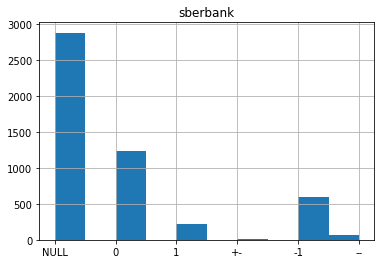

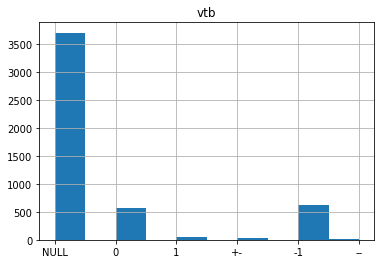

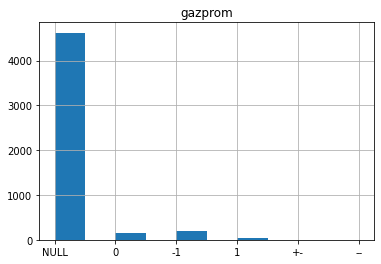

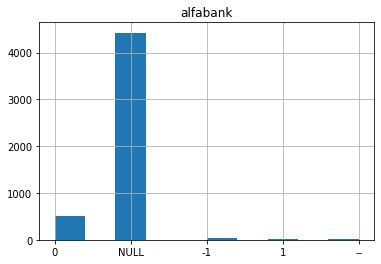

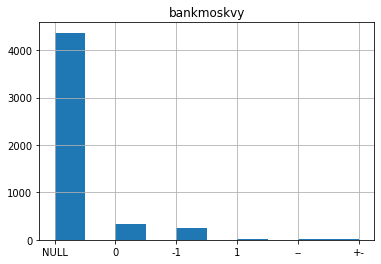

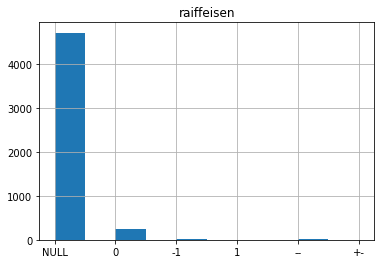

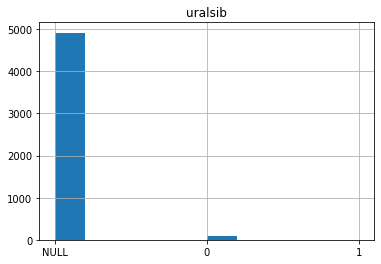

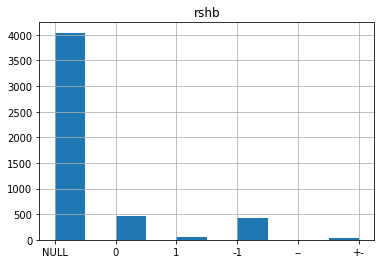

In [0]:
banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']
t, b = 0, 0
for bank in banks:
    df[bank].hist()
    plt.title(bank)
    t, b =plt.xlim()
    plt.show()

# Text processing

In [0]:
def convert(text):
    tokens = nltk.tokenize.wordpunct_tokenize(text)
    res = ''
    for token in tokens:
        if len(token) > 2:
            token = token.replace(u'ё', u'е')
            word = morph.parse(token)[0].normal_form
            if len(word) > 0:
                if word == 'банка':
                    word = 'банк'
                res += word + ' '
    return res

In [0]:
df.text = df.text.apply(convert)

In [0]:
vw = df.apply(lambda x: str(x['id']) + ' |text ' + x['text'], axis = 1)
print(len(vw))
vw.head()

5000


0              1 |text взять кредит тюмень альфа банк 
1                  2 |text мнение кредитный карта втб 
2    3 |text райффайзенбанк снижение ключевой ставк...
3    4 |text современный состояние кредитный поведе...
4                  5 |text главный чтоб банк сбер втб 
dtype: object

In [0]:
with open(gDrivePath + '/vw_bank_train.txt', 'w') as fout:
    for line in vw:
        fout.write(line + '\n')

# TM

In [0]:
# batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + '/vw_bank_train.txt', data_format='vowpal_wabbit', collection_name='vw_bank_train', target_folder=gDrivePath + '/batches_btr')

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + '/batches_btr', data_format = 'batches')

In [0]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary

artm.Dictionary(name=ab54d897-4f2d-4972-b519-17ea03de0a73, num_entries=4096)

In [0]:
def print_topic_top_words(model, metric):
    for topic_name in model.topic_names:
      print(topic_name + ': '),
      try:
          print(", ".join(model.score_tracker[metric].last_tokens[topic_name]))
      except:
          print("Not enough unigrams in a topic")
          print()

## PLSA

In [0]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(7)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [0]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreP', class_id='text', eps=1e-3))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreP', eps=1))
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScoreP', num_tokens=15, class_id='text'))

In [0]:
model_plsa.initialize(dictionary=dictionary)

In [0]:
%%time
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 3.44 s, sys: 38.1 ms, total: 3.48 s
Wall time: 2.25 s


In [0]:
print(model_plsa.score_tracker['SparsityPhiScoreP'].last_value)
print(model_plsa.score_tracker['SparsityThetaScoreP'].last_value)

0.9708077311515808
0.9593999981880188


In [0]:
print_topic_top_words(model_plsa, 'TopTokensScoreP')

topic_0: 
сбербанк, втб, газпромбанк, для, мочь, список, сми, россия, санкционный, ипотечный, бизнес, включить, клиент, рынок, быть
topic_1: 
банк, под, попасть, втб, сбербанк, москва, санкция, список, санкционный, новый, сша, российский, евросоюз, виза, дочка
topic_2: 
сбер, сбербанк, весь, что, быть, я, деньга, это, оао, тот, работать, если, программа, один, новость
topic_3: 
втб, россельхозбанк, санкция, банк, сша, москва, против, ввести, газпромбанк, вэб, российский, внешэкономбанк, попросить, это, оск
topic_4: 
кредит, сбербанк, потребительский, россия, онлайн, ставка, заявка, наличный, лицо, кредитование, процент, без, ипотечный, процентный, физический
topic_5: 
карта, сбербанк, кредит, кредитный, взять, как, россельхозбанк, оформить, получить, год, рубль, август, работа, россия, через
topic_6: 
банк, кредит, альфа, москва, взять, автокредит, калькулятор, райффайзный, райффайзенбанк, уралсиб, условие, втб, отзыв, какой, райфайзный


In [0]:
F = model_plsa.get_theta()
F#.to_csv(gDrivePath+f'/data/plsa_theta.csv')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
topic_0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.811371,0.000000,0.000000,0.000000,0.382403,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.188379,0.0,0.000000,0.000000,0.000000,0.234798,0.000000,0.000000,0.000000,0.000000,0.000000,0.599992,0.793067,0.000000e+00,...,0.000000,0.00000,0.000000,0.0,0.000000,0.195228,0.000000e+00,0.0,0.000000,0.331649,0.000000,0.195760,0.000000,0.186044,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.295383,0.000000,0.0,0.109475,0.113907
topic_1,0.0,0.000000,0.000000,0.000000,0.000000,0.488854,0.000000,0.000000,0.275959,0.00,0.274473,0.276182,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.491446e-01,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.464303,0.233266,0.000000,0.000000,0.000000,0.000000,0.000000,1.485742e-13,...,0.386804,0.00000,0.124976,0.0,0.000000,0.000000,1.462721e-07,0.0,0.222943,0.000000,0.000000,0.000000,0.000000,0.000000,0.275958,0.496950,0.0,0.000000,0.000000,0.000000,4.227894e-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3.074567e-01,0.386167,0.0,0.0,0.000000,0.00,0.0,0.239466,0.000000,0.0,0.000000,0.000000
topic_2,0.0,0.000000,0.336229,0.389821,0.600064,0.000000,0.000000,0.333746,0.000000,0.00,0.000000,0.361168,0.000000,0.0,0.000000,0.000000,0.194306,0.000000,0.000000,0.456261,4.000004e-01,0.000000,1.368836e-01,0.00000,0.142727,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206933,0.000000e+00,...,0.000000,0.00000,0.777385,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.217231,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.352826,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.326684,0.721580
topic_3,0.0,0.249969,0.000000,0.000000,0.249977,0.000000,0.189702,0.312513,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.211219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.199971,4.170159e-16,0.00000,0.282617,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002995,0.000000,0.000000,0.000000e+00,...,0.000000,0.00000,0.000000,0.0,0.333317,0.258097,0.000000e+00,0.0,0.000000,0.000000,0.333333,0.000000,0.182816,0.813956,0.000000,0.003030,1.0,0.249982,0.000000,0.000000,3.696927e-12,0.000000,0.0,0.323974,0.000000,0.0,0.209791,0.000000,2.212331e-11,0.000000,0.0,0.0,0.176224,0.25,0.0,0.000000,0.000000,0.0,0.000000,0.000000
topic_4,0.0,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.353741,0.724041,0.00,0.000000,0.000000,0.499703,0.0,0.000000,0.000000,0.175014,0.357534,0.306208,0.156360,9.443976e-14,0.241934,0.000000e+00,0.00000,0.000000,0.259536,0.000000,0.0,0.000000,0.665947,0.056358,0.765202,0.318797,0.419138,0.000000,0.607892,0.407901,0.000000,0.000000,3.328273e-01,...,0.000000,0.24962,0.000000,1.0,0.666681,0.546675,2.017775e-01,0.0,0.269016,0.000000,0.000000,0.432938,0.003173,0.000000,0.724042,0.000000,0.0,0.750018,0.004905,0.498747,0.000000e+00,0.357555,0.0,0.000000,0.498739,1.0,0.000000,0.661634,0.000000e+00,0.000000,1.0,1.0,0.263699,0.00,0.0,0.465151,0.999981,0.0,0.000000,0.000000
topic_5,0.0,0.750031,0.000000,0.610179,0.000000,0.200882,0.000000,0.000000,0.000000,0.75,0.218243,0.078203,0.000000,1.0,0.000000,0.188629,0.000000,0.284419,0.443792,0.000000,5.999997e-01,0.558095,2.553674e-01,0.70538,0.000000,0.220254,0.000000,0.0,0.1873

# Разбивка по классам

In [0]:
df['classes'] = F.apply(lambda x: np.argmax(x), axis=0).values

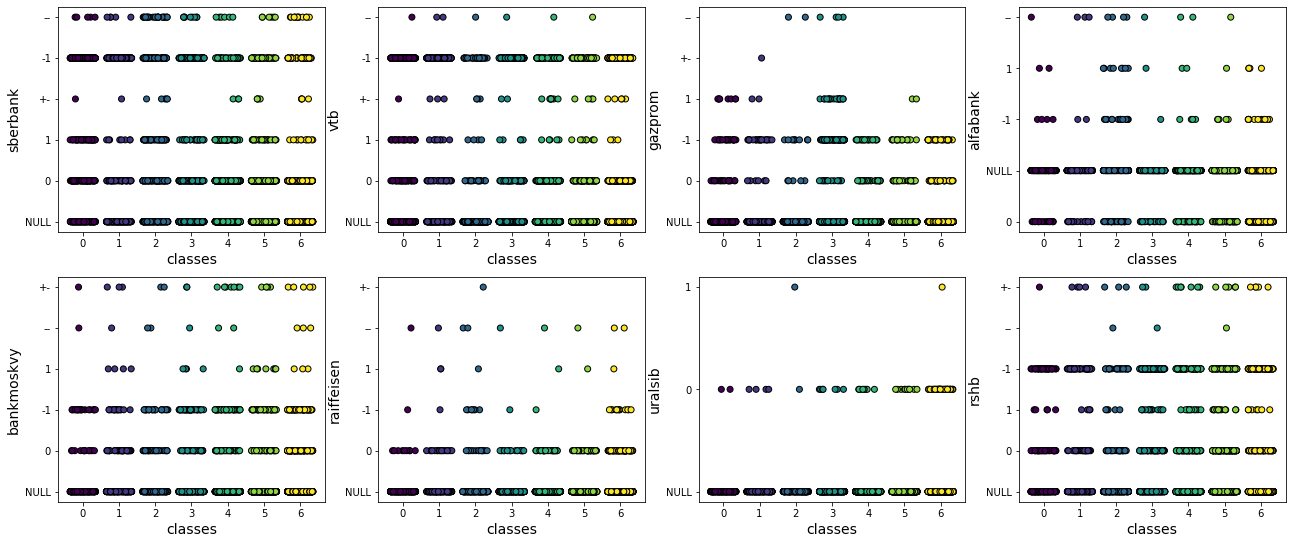

In [0]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

plt.figure(figsize = (22, 24))
for i in range (4, 12):
    plt.subplot(5, 4, i-3)
    plt.scatter(jitter(df['classes']), df.iloc[:, i], c=df["classes"], edgecolors="black")
    plt.xlabel('classes', fontsize=14)
    plt.ylabel(str(df.columns[i]), fontsize=14)